In [78]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [79]:
def initialize(context):
    dji = [
          'AAPL',
          'AXP',
          'BA',
          'CAT',
          'CSCO',
          'CVX',
          'DIS',
          'DWDP', # ? "DD" or "GE"
          'GS',
          'HD',
          'IBM',
          'INTC',
          'JNJ',
          'JPM',
          'KO',
          'MCD',
          'MMM',
          'MRK',
          'MSFT',
          'NKE',
          'PFE',
          'PG',
          'TRV',
          'UNH',
          'UTX', #RTX
          'V',
          'VZ',
          'WBA',
          'WMT',
          'XOM']
    
    context.universe = [symbol(s) for s in dji]
    context.history_window = 20
    context.stocks_to_hold = 10
    context.set_benchmark(False)
    
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

def handle_data(context, data):
    hist = data.history(context.universe, "close", context.history_window, "1d")
    perf_table = hist.apply(month_perf).sort_values(ascending=False)
    
    buy_list = perf_table[:context.stocks_to_hold]
    the_rest = perf_table[context.stocks_to_hold:]
    
    #Place target buy orders for top N stocks
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        
        # Place order 
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)
    
    # Make sure we are flat the rest
    for stock, perf in the_rest.iteritems():
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)
            
def analyze(context, perf):
    returns, positions, transactions  = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)


In [80]:

start = pd.Timestamp('2002-1-1', tz='utc')
end = pd.Timestamp('2017-12-31', tz='utc')

Start date,2002-01-02
End date,2017-12-29
Total months,191
,Backtest
Annual return,7.1%
Cumulative returns,197.2%
Annual volatility,18.7%
Sharpe ratio,0.46
Calmar ratio,0.12
Stability,0.79
Max drawdown,-58.0%


/Users/dmitrymikhaylov/opt/anaconda3/envs/zip35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.00,2007-10-31,2009-03-09,2013-03-22,1408
1,37.47,2002-05-17,2002-10-09,2004-11-12,651
2,13.04,2015-07-16,2015-08-25,2016-03-11,172
3,10.06,2007-07-19,2007-08-16,2007-10-29,73
4,9.35,2005-03-07,2005-04-20,2005-09-06,132


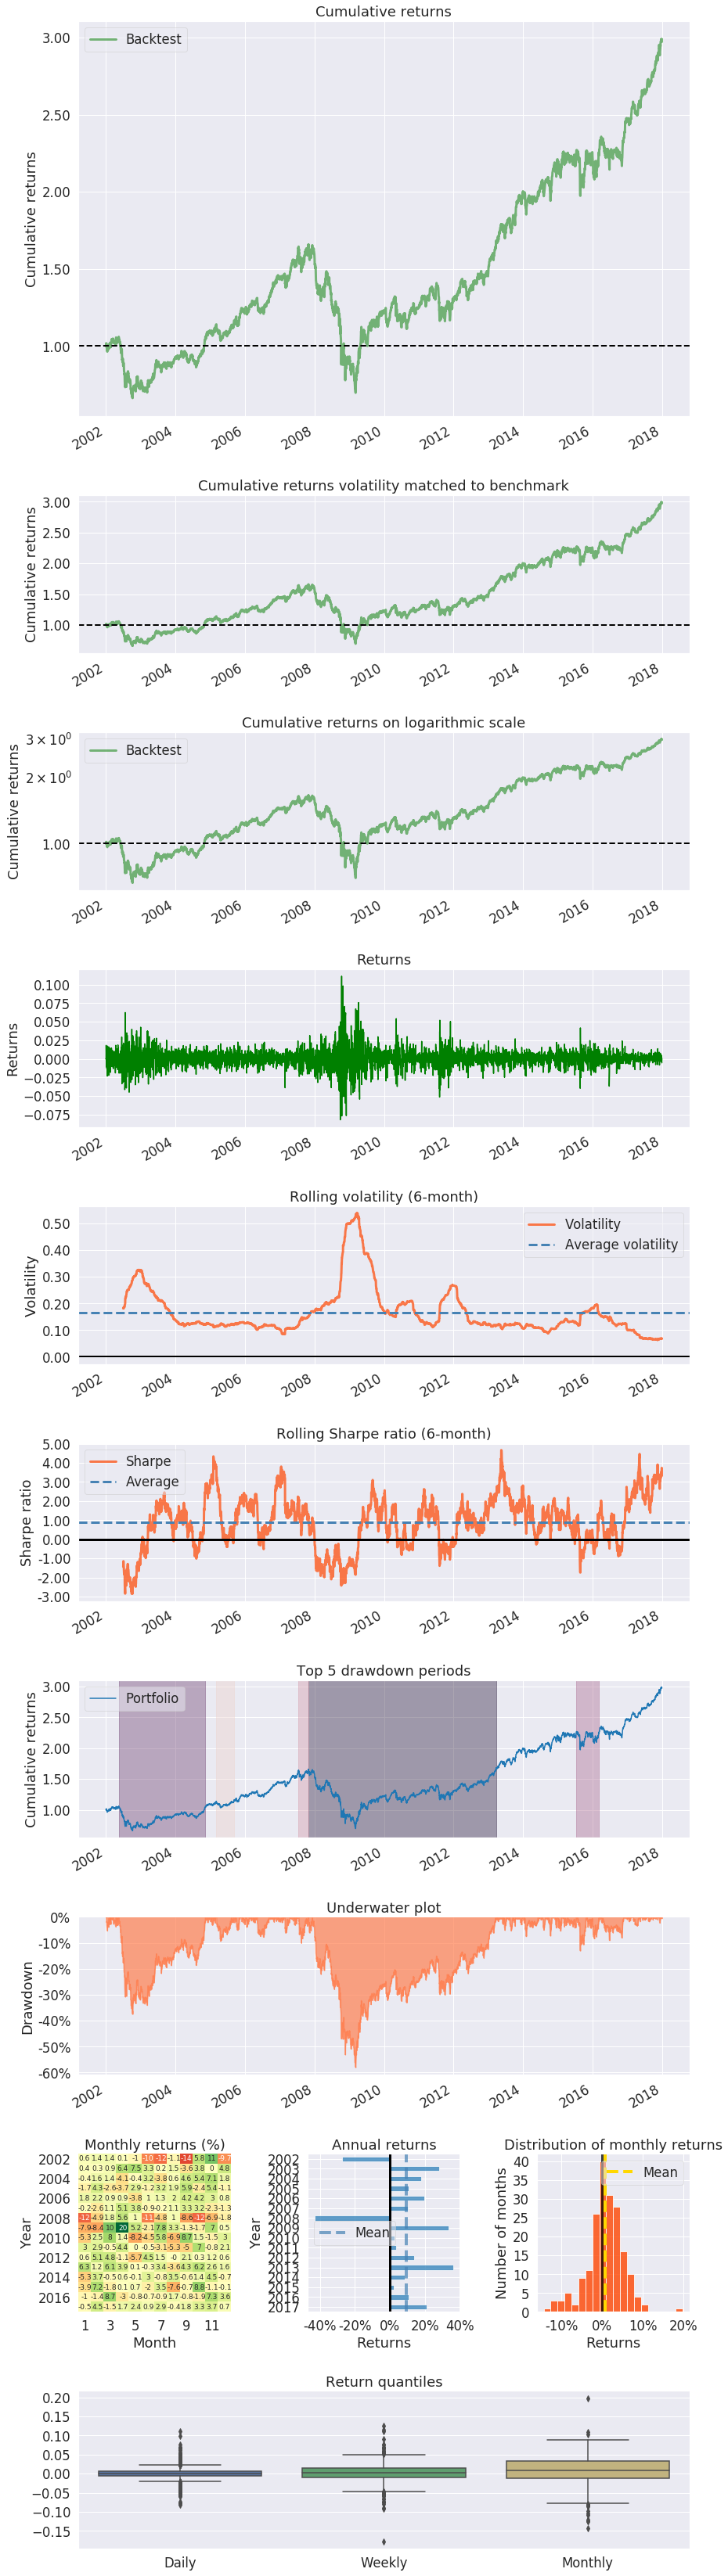

In [81]:
result = run_algorithm(start=start, end=end, 
                      initialize=initialize, 
                      analyze=analyze,
                      capital_base=10000,
                      data_frequency='daily', bundle='quandl')

In [82]:
result.shape

(4028, 37)

In [83]:
for column in result:
    print(column)

algo_volatility
algorithm_period_return
alpha
benchmark_period_return
benchmark_volatility
beta
capital_used
ending_cash
ending_exposure
ending_value
excess_return
gross_leverage
long_exposure
long_value
longs_count
max_drawdown
max_leverage
net_leverage
orders
period_close
period_label
period_open
pnl
portfolio_value
positions
returns
sharpe
short_exposure
short_value
shorts_count
sortino
starting_cash
starting_exposure
starting_value
trading_days
transactions
treasury_period_return


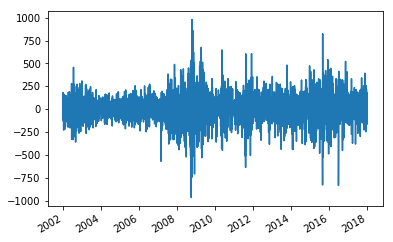

In [84]:
result['pnl'].plot();

## Day Snapshot

In [85]:
# Select day to view
day = '2009-03-17'

In [86]:
result.loc[day]

algo_volatility                                                     0.218112
algorithm_period_return                                            -0.189552
alpha                                                            -0.00337265
benchmark_period_return                                            -0.494217
benchmark_volatility                                                0.418629
beta                                                                 0.30424
capital_used                                                               0
ending_cash                                                         -54.7995
ending_exposure                                                      8159.28
ending_value                                                         8159.28
excess_return                                                              0
gross_leverage                                                       1.00676
long_exposure                                                        8159.28

In [87]:
# Get portfolio value and position for this day
port_value = result.loc[day, 'portfolio_value']
day_positions = result.loc[day, 'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with positions info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker, 'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker, 'pnl'] =df.loc[ticker, 'value'] - (pos['amount'] * pos['cost_basis'])
    
# Add cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

In [88]:
df

,value,pnl
IBM,836.19,54.4093
GS,890.91,91.4805
AAPL,896.94,59.6926
KO,787.55,-35.9605
CSCO,823.14,88.8321
INTC,879.1,154.159
WMT,750,38.9296
V,718.77,11.7237
HD,773.28,92.864
TRV,803.4,108.033


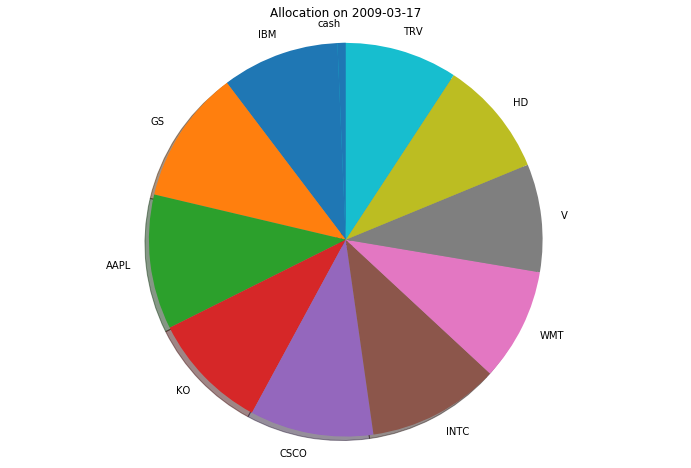

In [89]:
# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

Text(0.5, 1.0, 'Open PnL on 2009-03-17')

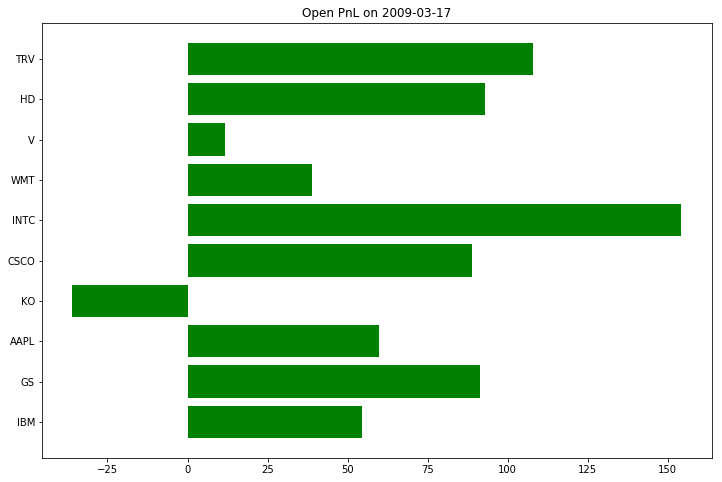

In [90]:
# Make a pie chart for open PnL
fig, ax2 = plt.subplots(figsize=(12, 8))
pnl_df = df.drop('cash')
ax2.barh(pnl_df.index, pnl_df['pnl'], align='center', color='green', ecolor='black')
ax2.set_title('Open PnL on {}'.format(day))

## Custom Time Series Analytics

In [76]:
# Settings
window = 252
year_length = 252

# Copy the colums we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length / len(ts))) -1

# Function fro drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) -1

# Getting a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

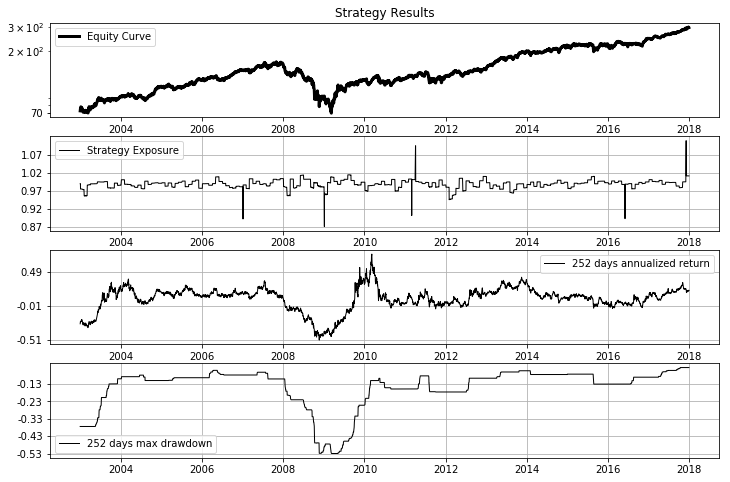

In [77]:
# Make a figure
fig = plt.figure(figsize=(12, 8))

# Make the base lower, so the graph is easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], linestyle='-', color='black', label='Equity Curve', linewidth=3)

ax.set_yscale("log")
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax.legend()
ax.grid(False)

ax2 = fig.add_subplot(412)
ax2.plot(df['gross_leverage'], 
         label='Strategy Exposure'.format(window), 
         linestyle='-', 
         color='black', 
         linewidth=1.0)
ax2.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.05))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax2.legend()
ax2.grid(True)


ax3 = fig.add_subplot(413)
ax3.plot(df['annualized'], 
         label='{} days annualized return'.format(window), 
         linestyle='-', 
         color='black', 
         linewidth=1.0)
ax3.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax3.legend()
ax3.grid(True)

ax4 = fig.add_subplot(414)
ax4.plot(df['drawdown'],
         label='{} days max drawdown'.format(window),
         linestyle='-',
         color='black',
         linewidth=1.0)
ax4.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1))
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax4.legend()
ax4.grid(True)
plt.show()